# Treinamento QAM AWGN

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from libs.commpy_mod import SISOFlatChannel

from files_01_detection.const_mod import generate_symbols, Model
from files_01_detection.const_analyzer import plot_decision_boundary, theoretical_error, ser, plot_confusion_matrix, plot_symbols
 
%matplotlib inline

2023-04-25 16:33:24.393469: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-25 16:33:24.393495: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-25 16:33:24.421933: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-25 16:33:25.126764: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-25 16:33:25.126846: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

In [2]:
total_num_symbols  = 1000000    # Number of transmitted symbols to be used for training and test
train_fraction = 0.4 # Fraction of whole data to be used for training (the remaining is for testing)
code_rate    = 1       # Rate of the used code
Es           = 1       # Average symbol energy
Mod = 'QAM'
channel_type = 'awgn' # 'awgn' or 'crazy'
M            = [16, 4]      # PSK modulation

In [3]:
def error(amostras, model, mod, M, channel_type, Es, code_rate, snr):
    frac = 10000
    error = 0
    a = amostras
    for i in range(amostras // frac + 1):
        if a < frac:
            frac = amostras % frac
        sub_amostras =  conjunto(Mod, frac, M, channel_type, Es, code_rate, snr, False, scaler.transform)
        error += ser(model, tf.reshape(tf.convert_to_tensor(sub_amostras[0]), [-1, 3]),
                          tf.reshape(tf.convert_to_tensor(sub_amostras[1]), [-1, 1]), nn=True)
        a -= frac
    error /= amostras / frac
    return error

def conjunto(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB, symb=False, scaler=None):

    symbs, indices, channel_output = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, [SNR_dB[0]])
    x = np.stack([np.real(channel_output[0][:]),
                    np.imag(channel_output[0][:])], axis=1)

    if scaler is not None:
        x = scaler(np.concatenate((x, np.array([channel_output[1]]).T), axis=1))
    else:
        x = np.concatenate((x, np.array([channel_output[1]]).T), axis=1)
    
    x = x.reshape(1,-1,3)
    
    for i in range(1, len(SNR_dB)):
        a, b, c = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB[i])
        
        d = np.stack([np.real(c[0][:]), np.imag(c[0][:])], axis=1)
        
        if scaler is not None:
            d = scaler(np.concatenate((d, np.array([c[1]]).T), axis=1))
        else:
            d = np.concatenate((d, np.array([c[1]]).T), axis=1)
        
        symbs = np.vstack((symbs, a))
        indices = np.vstack((indices, b))
        channel_output = np.vstack((channel_output, c))
        x = np.vstack((x, d.reshape(1,-1,3)))
    
    y = np.float_(indices)
        
    if symb:
        return x, y, symbs
    else:
        return x, y

In [4]:
x_out = []
y_out = []
symbs = []

In [5]:
x_out.append(np.fromfile('Random_Data/SNR_8-12/Rayleigh/16-QAM/x_rand.dat', dtype=np.dtype('float64')).reshape((-1,3)))
y_out.append(np.fromfile('Random_Data/SNR_8-12/Rayleigh/16-QAM/y_rand.dat', dtype=np.dtype('float64')))
symbs.append(np.fromfile('Random_Data/SNR_8-12/Rayleigh/16-QAM/symb.dat', dtype=np.dtype('complex128')).reshape((1,-1)))

In [6]:
x_out.append(np.fromfile('Random_Data/SNR_8-12/Rayleigh/4-QAM/x_rand.dat', dtype=np.dtype('float64')).reshape((-1,3)))
y_out.append(np.fromfile('Random_Data/SNR_8-12/Rayleigh/4-QAM/y_rand.dat', dtype=np.dtype('float64')))
symbs.append(np.fromfile('Random_Data/SNR_8-12/Rayleigh/4-QAM/symb.dat', dtype=np.dtype('complex128')).reshape((1,-1)))

In [7]:
# Generate dataset
# Train
train_size = int(train_fraction*total_num_symbols) #data used for training
X_train = []
y_train = []
X_test = []
y_test = []
for i in range(len(M)):
    y_train.append(y_out[i][:train_size])
    X_train.append(x_out[i][:train_size])

    # Test
    y_test.append(y_out[i][train_size:])
    X_test.append(x_out[i][train_size:])

    scaler = StandardScaler()
    scaler.fit(X_train[i])  # Don't cheat - fit only on training data
    X_train[i] = scaler.transform(X_train[i])
    X_test[i] = scaler.transform(X_test[i])


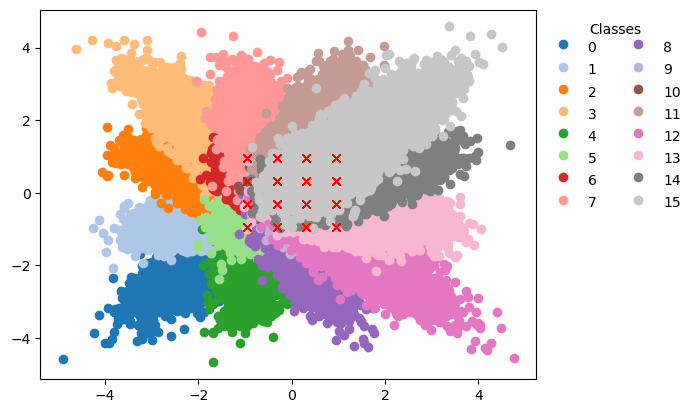

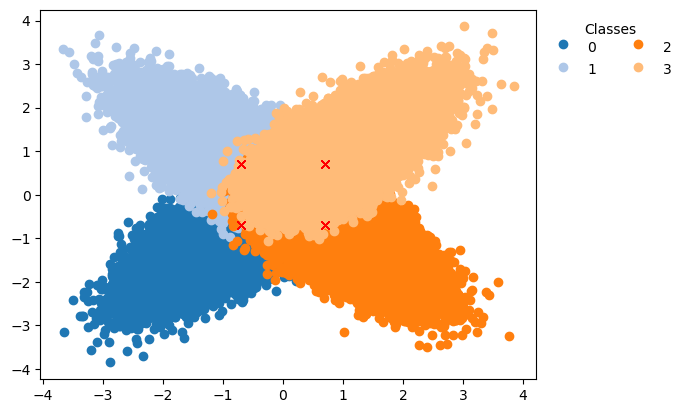

In [8]:
for i in range(len(M)):
    plot_symbols(X_train[i], y_train[i], M[i], symbs[i])

In [9]:
n_inputs = 3

In [10]:
n_redes = 3
n_hidden = [[150, 80, 50],
            [300, 180, 90, 40],
            [500, 380, 240, 135, 80]]

n_outputs = M
learning_rate = [0.01, 0.01, 0.001]
n_epochs = [50, 50, 50]
batch_size = [8000, 16000, 24000]
momentum = [0.7, 0.8, 0.9]

In [11]:
y_train_tf = tf.reshape(tf.convert_to_tensor(y_train), [len(M), -1, 1])
y_test_tf = tf.reshape(tf.convert_to_tensor(y_test), [len(M), -1, 1])
X_test_tf = tf.convert_to_tensor(X_test)
X_train_tf = tf.convert_to_tensor(X_train)

2023-04-25 17:09:05.541783: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-25 17:09:05.541922: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-04-25 17:09:05.542035: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-04-25 17:09:05.542119: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-04-25 17:09:05.542207: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

### Usando API Keras

In [12]:
inputs = tf.keras.Input(shape=(n_inputs,))
output = []

for k in range(len(M)):
    for i in range(n_redes):
        x = inputs
        for j in range(len(n_hidden[i])):
            x = tf.keras.layers.Dense(n_hidden[i][j], activation="elu", kernel_initializer="glorot_normal")(x)
        output.append(tf.keras.layers.Dense(n_outputs[k], kernel_initializer="glorot_normal")(x))
        del x

In [13]:
model_QAM = []
for k in range(len(M)):
    for i in range(n_redes):
        model_QAM.append(tf.keras.Model(inputs=inputs, outputs=output[i + 3*k]))

        model_QAM[i + 3*k].compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=learning_rate[i], momentum=momentum[i], nesterov=True),
                     metrics=["accuracy"])

        history = model_QAM[i + 3*k].fit(X_train_tf[k], y_train_tf[k], batch_size=batch_size[i], epochs=n_epochs[i], shuffle=True)

        tests_score = model_QAM[i + 3*k].evaluate(X_test_tf[k], y_test_tf[k])
        print("\nTest loss:", tests_score[0])
        print("Test accuracy:", tests_score[1])
        print(f"Taxa de erro simbólica de {(1 - tests_score[1]):.2%}\n")

model_QAM = np.array(model_QAM).reshape(len(M), -1)

Epoch 1/50
50/50 [==============================] - 1s 15ms/step - loss: 2.4633 - accuracy: 0.2245
Epoch 2/50
50/50 [==============================] - 1s 15ms/step - loss: 1.9942 - accuracy: 0.3372
Epoch 3/50
50/50 [==============================] - 1s 15ms/step - loss: 1.7053 - accuracy: 0.4441
Epoch 4/50
50/50 [==============================] - 1s 15ms/step - loss: 1.5359 - accuracy: 0.5077
Epoch 5/50
50/50 [==============================] - 1s 15ms/step - loss: 1.4283 - accuracy: 0.5451
Epoch 6/50
50/50 [==============================] - 1s 15ms/step - loss: 1.3509 - accuracy: 0.5744
Epoch 7/50
50/50 [==============================] - 1s 15ms/step - loss: 1.2906 - accuracy: 0.5962
Epoch 8/50
50/50 [==============================] - 1s 15ms/step - loss: 1.2428 - accuracy: 0.6094
Epoch 9/50
50/50 [==============================] - 1s 15ms/step - loss: 1.2057 - accuracy: 0.6173
Epoch 10/50
50/50 [==============================] - 1s 15ms/step - loss: 1.1777 - accuracy: 0.6216
Epoch 11/

Modelo 16-QAM:



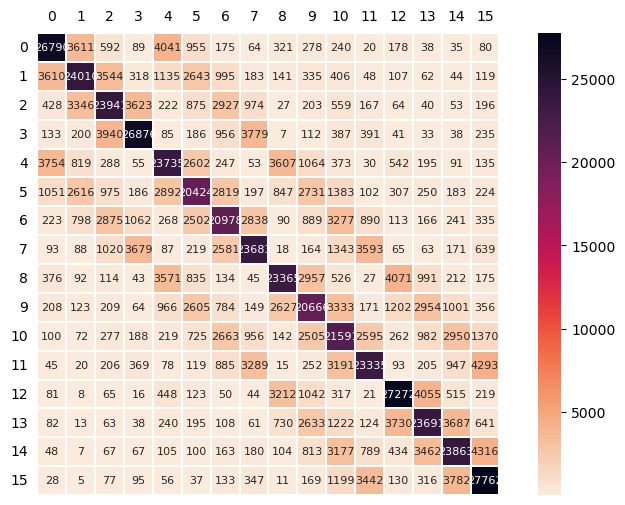

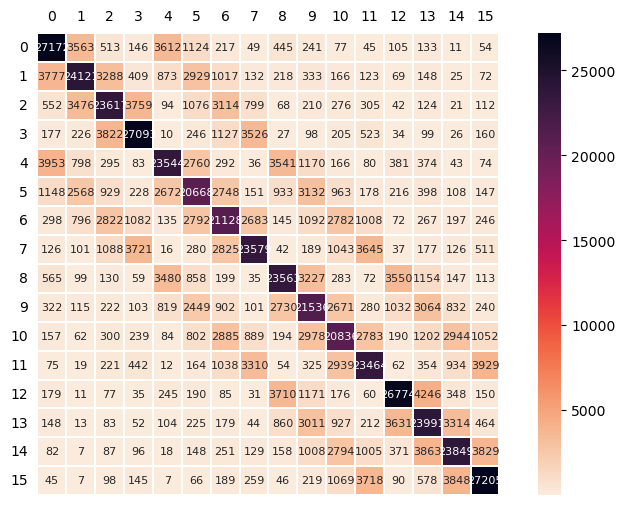

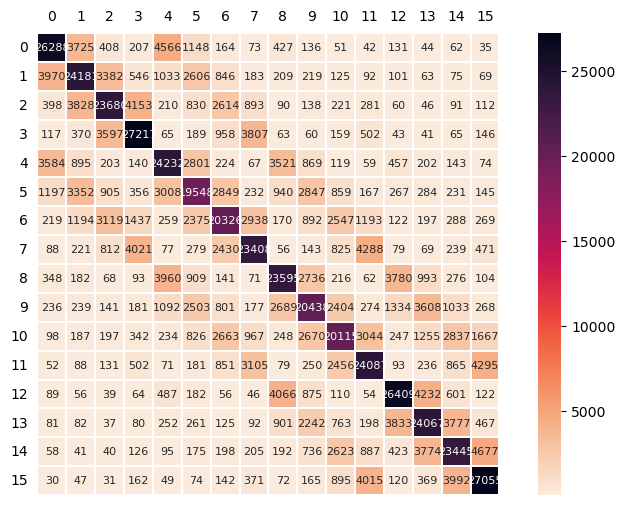

Modelo 4-QAM:



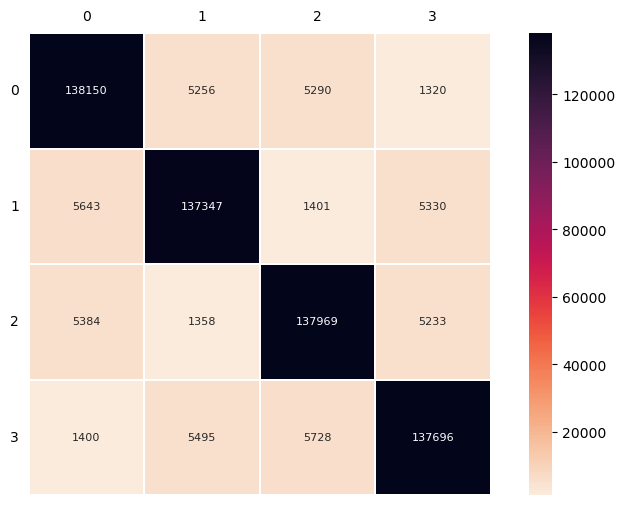

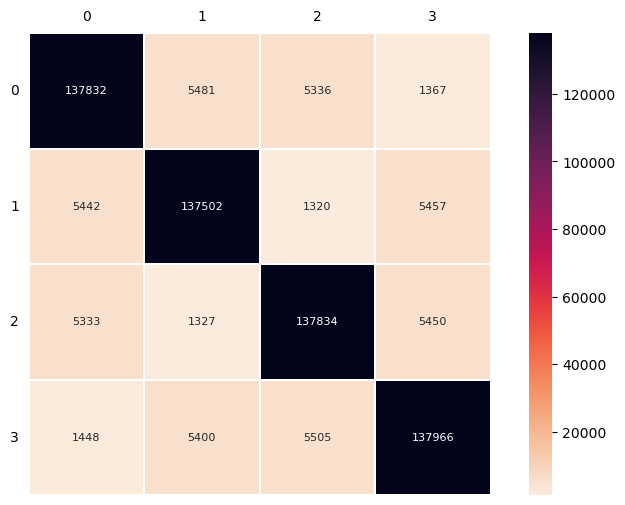

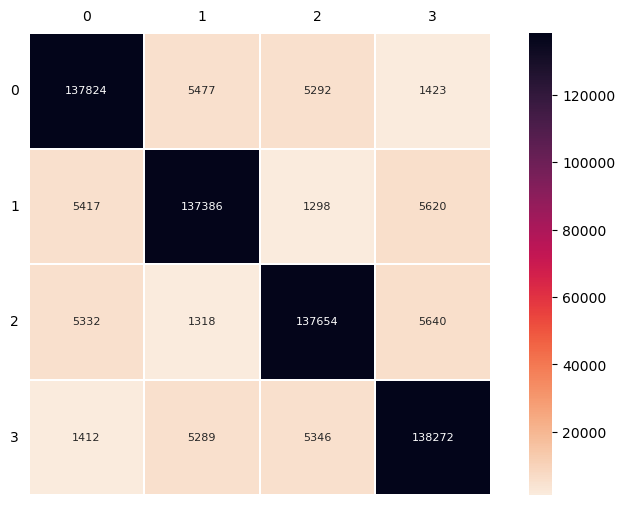

In [14]:
for i in range(len(M)):
    print(f'Modelo {M[i]}-QAM:\n')
    for j in range(n_redes):
        plot_confusion_matrix(model_QAM[i][j], X_test_tf[i], y_test_tf[i], M[i], nn=True)
#plot_decision_boundary(modelK, X_train, y_train, legend=True, nn=True)
#plot_decision_boundary(modelK, X_train, y_train, legend=True, nn=True, plot_training=False)

## Avaliação do modelo em diferentes faixas de relação sinal/ruído

### QAM | AWGN

Obs: Subdividir amostras em conjuntos menores e realizar o treinamento (1000 subamostros por exemplo). Fazer a verificação de bits sem aproximação. Testar em um intervalo maior para verificar se a rede diverge em algum momento.

In [15]:
Mod = "QAM"
channel_type = "awgn"
init_scale = 1
interval = [26, 15]
passo = 2

In [16]:
Teo_SNRs = [[theoretical_error(Mod, M[k], init_scale + i, channel_type) for i in range(0, interval[k], passo)] for k in range(len(M))]

In [ ]:
error_rate = [([[error(int(100 / (Teo_SNRs[k][int(i / passo)] * np.log2(M[k]))), model_QAM[k][j], Mod, M[k], channel_type, Es, code_rate, [init_scale + i]) for i in range(0, interval[k], passo)] for j in range(n_redes)]) / (tf.math.log(float(M[k]))/tf.math.log(2.)) for k in range(len(M))]

In [ ]:
error_rate

In [ ]:
np.mean(error_rate - Teo_SNRs)

In [ ]:
import matplotlib.ticker as tick

for k in range(len(M)):
    y1 = Teo_SNRs[k]
    x = range(init_scale, init_scale + interval[k], passo)

    fig, ax = plt.subplots(1,1)

    ax.plot(x, y1, 'go-', label='Theoretical Curve', linewidth=2)
    [ax.plot(x, error_rate[k][i], 's--', label=f'Empirical Curve (Rede {i + 1})') for i in range(n_redes)]

    ax.set_title(f'{M[k]}-QAM - AWGN')
    ax.set_xlabel('SNR_dB')
    ax.set_ylabel('Taxa de erro por bit')

    def y_fmt(x, y):
        return '{:2.1e}'.format(x)

    ax.set_yscale("log")
    ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
    #plt.plot(x2, y2, 'rs--',  label='line 2')

    plt.legend()
    plt.show()